Lingyi Zhang (lz1714) | Python3

# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstile data

In [1]:
from __future__ import print_function, division
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.cluster import KMeans
import datetime as dt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from scipy.spatial.distance import cdist, pdist
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
matplotlib.rcParams['font.size'] = 18

#### Each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/21/2010 to 02/21/2014. 

In [3]:
mtaRide = np.load('MTA_Fare.npy')

In [4]:
mtaRide = np.where(mtaRide<0, np.nan, mtaRide)

In [5]:
print ('original shape: {}'.format(mtaRide.shape))
mta_allsum_station = np.nansum(mtaRide, axis=0)
print ('all stations shape: {}'.format(mta_allsum_station.shape))
mta_allsum_type = np.nansum(mtaRide, axis=1)
print ('all ride type shape: {}'.format(mta_allsum_type.shape))

original shape: (600, 23, 194)
all stations shape: (23, 194)
all ride type shape: (600, 194)


In [6]:
dayrange = pd.to_datetime('2014-02-21', format='%Y/%m/%d') - pd.to_datetime('2010-05-21', format='%Y/%m/%d')
weeks = dayrange.days / 7
print ('There are {} weeks between 2010-05-21 and 2014-02-21'.format(weeks))

There are 196.0 weeks between 2010-05-21 and 2014-02-21


# So I will assume the actual day range of this data is 2010-05-28 to 2014-02-14

## Task 1: 
#### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
#### Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.

In [7]:
drange = pd.date_range(dt.date(2010, 5, 28), periods=194, freq='W').tolist()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


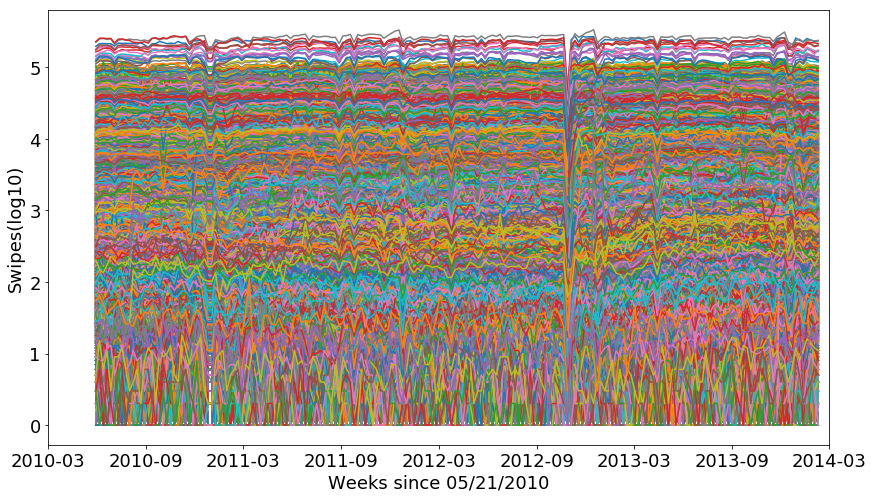

Figure 1. swipes from 2010-05-28 to 2014-02-14, all stations and types. Some time shows obvious drops among all stations and types.


In [8]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
ax.set_xlim(dt.date(2010,3,1), dt.date(2014,3,1))
for i in range (600):
    for j in range (23):
        ax.plot(drange, np.log10(mtaRide[i][j]))
ax.set_xlabel('Weeks since 05/21/2010')
ax.set_ylabel('Swipes(log10)')
plt.show()
print ('Figure 1. swipes from 2010-05-28 to 2014-02-14, all stations and ' +
       'types. Some time shows obvious drops among all stations and types.')

In [9]:
rides = np.nansum(mta_allsum_station, axis=0)
print(rides.shape)

(194,)


In [10]:
#thresholds
mean = np.nanmean(rides, axis=0)
std = np.nanstd(rides)
thresholds = [mean + 3 * std, mean - 3 * std]
print ("mean by day {:.2f}".format(mean))
print ("stdev by day {:.2f}".format(std))
print ("3-sigma thresholds {:.2f} {:.2f}".format(*thresholds))

mean by day 29781349.87
stdev by day 2983960.42
3-sigma thresholds 38733231.14 20829468.61


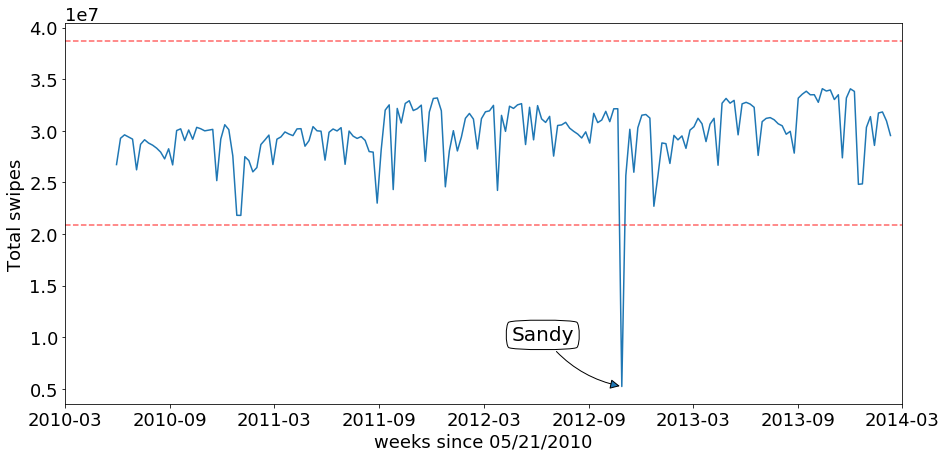

Figure 2. total swipes from 2010-05-28 to 2014-02-14. One point is below 3 sigma, which happened right after the Sandy.


In [11]:
fig, ax1 = plt.subplots(1, 1, figsize=(15, 7))
ax1.set_xlim(dt.date(2010,3,1), dt.date(2014,3,1))
ax1.plot(drange, rides)
#ax1.plot(lowestpoint, rides[lowestpoint], marker='o', c='r')
ax1.plot([dt.date(2010,3,1), dt.date(2014,3,1)], [thresholds[0], thresholds[0]], 'r--', alpha=0.6)
ax1.plot([dt.date(2010,3,1), dt.date(2014,3,1)], [thresholds[1], thresholds[1]], 'r--', alpha=0.6)
ax1.annotate('Sandy', 
             xy=(dt.date(2012,10,28), rides.min()), 
             xycoords='data', xytext=(dt.date(2012,6,12),rides.min()+5*1e6), textcoords='data', size=20, va="center", 
             ha="center",bbox=dict(boxstyle="round4", fc="w"), arrowprops=dict(arrowstyle="-|>",
                                  connectionstyle="arc3,rad=0.2"))
plt.xlabel('weeks since 05/21/2010')
plt.ylabel('Total swipes')
plt.show()
print ('Figure 2. total swipes from 2010-05-28 to 2014-02-14. One point ' +
       'is below 3 sigma, which happened right after the Sandy.')

In [12]:
#extreme value
lowestpoint = np.where(rides == rides.min())[0][0]
print ('The extreme value happened: {}'.format(drange[lowestpoint]))

The extreme value happened: 2012-10-28 00:00:00


#### 2012-10-28 is the day Hurricane Sandy' first rainbands begin to affect New Jersey (learnt from Wikipedia). The most prominent event here is the Sandy.

## Task 2: 
### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

In [13]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [14]:
df = pd.DataFrame(mta_allsum_station.T, columns=ridetype)
df_rollingmean = df.rolling(5).mean()

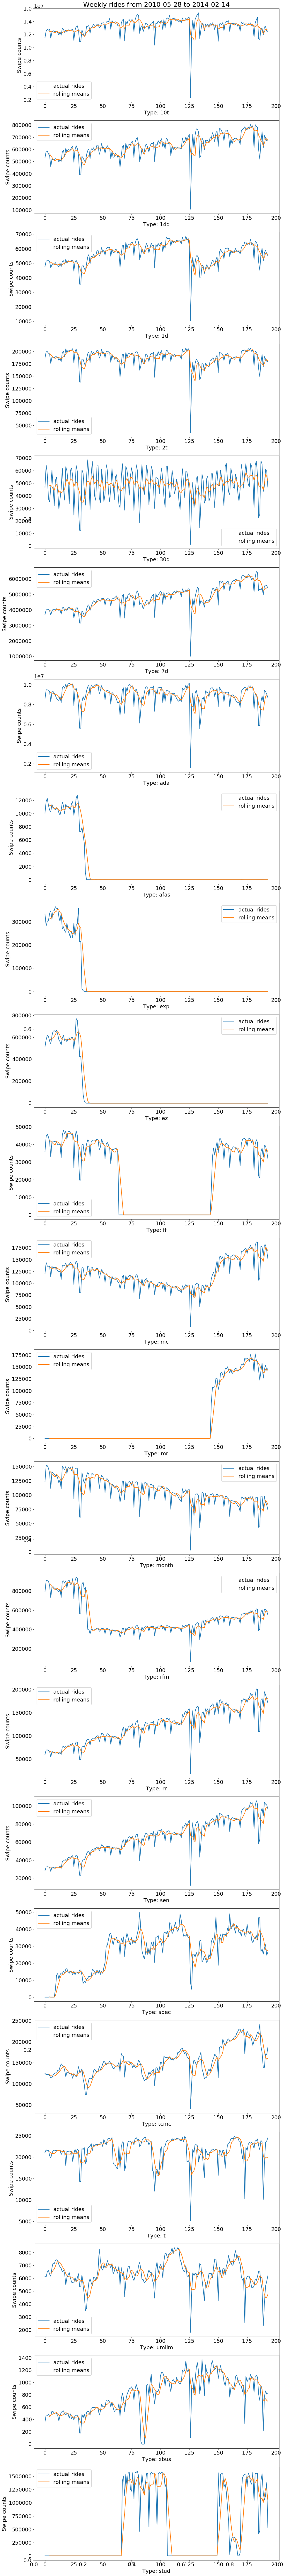

Figure 3. Sweipe counts of 23 different card types, with rolling means. These 23 types show different patterns thourgh time.


In [15]:
fig = plt.figure(figsize=(15,160), frameon=False)
plt.title('Weekly rides from 2010-05-28 to 2014-02-14', fontsize=22)
for i in range(23):
    ax = fig.add_subplot(23, 1, i+1)
    ax = df.iloc[:,i].plot(style='-', ms=5, lw=2, label='actual rides', legend=True)
    ax = df_rollingmean.iloc[:,i].plot(style='-', lw=2, label='rolling means', legend=True)
    ax.set_xlabel("Type: {}".format(ridetype[i]))
    ax.set_ylabel("Swipe counts")
    plt.legend(loc='best')
plt.show()
print ('Figure 3. Sweipe counts of 23 different card types, with rolling means. These 23 types show different ' + 
       'patterns thourgh time.')

#### ADFuller test:

In [16]:
def adf(ts):
    # Calculate ADF factors
    adftest = adfuller(ts)
    adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','# of Lags Used',
                                              'Number of Observations'])
    for key,value in adftest[4].items():
        adfoutput['Critical Value (%s)'%key] = value
    return adfoutput['p-value']

In [17]:
print ('ADFuller test results')
for i in range(23):
    print ('--------------------------')
    print ('Type: {}'.format(ridetype[i]))
    print ('p-value: {:.3f}'.format(adf(df.iloc[:,i])))
    if adf(df.iloc[:,i]) < 0.05:
        ratio = (np.mean(df[ridetype[i]][-10:])-np.mean(df[ridetype[i]][:10])) / np.mean(df[ridetype[i]][:10]) * 100
        if ratio > 0:
            print ('Stationary -- Increase by {:.3f}%'.format(ratio))
        else:
            print ('Stationary -- Decrease by {:.3f}%'.format(abs(ratio)))
    else:
        print ('Not Stationary'.format(ridetype[i]))

ADFuller test results
--------------------------
Type: 10t
p-value: 0.000
Stationary -- Increase by 2.180%
--------------------------
Type: 14d
p-value: 0.223
Not Stationary
--------------------------
Type: 1d
p-value: 0.233
Not Stationary
--------------------------
Type: 2t
p-value: 0.000
Stationary -- Decrease by 6.620%
--------------------------
Type: 30d
p-value: 0.002
Stationary -- Increase by 3.379%
--------------------------
Type: 7d
p-value: 0.526
Not Stationary
--------------------------
Type: ada
p-value: 0.000
Stationary -- Decrease by 10.016%
--------------------------
Type: afas
p-value: 0.087
Not Stationary
--------------------------
Type: exp
p-value: 0.033
Stationary -- Decrease by 99.999%
--------------------------
Type: ez
p-value: 0.118
Not Stationary
--------------------------
Type: ff
p-value: 0.536
Not Stationary
--------------------------
Type: mc
p-value: 0.872
Not Stationary
--------------------------
Type: mr
p-value: 0.931
Not Stationary
---------------------

## Task 3:
### Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [18]:
df1 = pd.DataFrame(mta_allsum_type.T)
df1.head()

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,126878.0,37306.0,6606.0,16378.0,18564.0,19987.0,12449.0,11091.0,10482.0,147187.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,149477.0,46464.0,6881.0,17408.0,19903.0,20625.0,13644.0,11659.0,11030.0,154826.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,152383.0,49359.0,7229.0,17595.0,19948.0,21225.0,13719.0,12037.0,10881.0,155958.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,160175.0,44849.0,5731.0,14242.0,16076.0,17412.0,11460.0,9809.0,9123.0,154914.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,162641.0,41509.0,7032.0,17589.0,20283.0,20909.0,14094.0,11944.0,10923.0,157628.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
df1.shape

(194, 600)

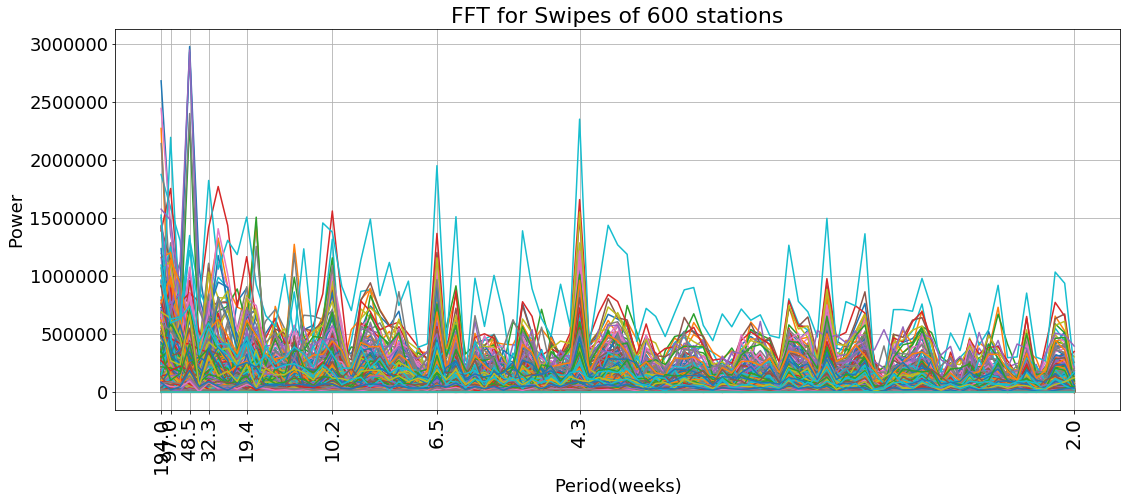

Figure 4. FFT for 600 stations. This figure revealed some possible periodic pantterns.


In [20]:
plt.figure(figsize=(18, 7))
peak = []
xrange = np.fft.rfftfreq(194, 1)[1:]
for i in range(600):
    f = np.abs(np.fft.rfft(df1[i])[1:])
    peak.append(f[3])
    plt.plot(xrange, f)
xt = xrange[[0, 1, 3, 5, 9, 18, 29, 44, -1]]
plt.xticks(xt, ["{:.1f}".format(1/f) for f in xt], fontsize=20, rotation=90)
plt.xlabel('Period(weeks)')
plt.ylabel('Power')
plt.title('FFT for Swipes of 600 stations', fontsize=22)
plt.grid(True)
plt.show()
print ('Figure 4. FFT for 600 stations. This figure revealed some possible periodic pantterns.')

In [21]:
print ("%.2f weeks"%(1.0 / np.fft.rfftfreq(194, 1.0)[0]))
print ("%.2f weeks"%(1.0 / np.fft.rfftfreq(194, 1.0)[1]))
print ("%.2f weeks"%(1.0 / np.fft.rfftfreq(194, 1.0)[3]))
print ("%.2f weeks"%(1.0 / np.fft.rfftfreq(194, 1.0)[5]))
print ("%.2f weeks"%(1.0 / np.fft.rfftfreq(194, 1.0)[9]))
print ("%.2f weeks"%(1.0 / np.fft.rfftfreq(194, 1.0)[18]))
print ("%.2f weeks"%(1.0 / np.fft.rfftfreq(194, 1.0)[29]))
print ("%.2f weeks"%(1.0 / np.fft.rfftfreq(194, 1.0)[44]))

inf weeks
194.00 weeks
64.67 weeks
38.80 weeks
21.56 weeks
10.78 weeks
6.69 weeks
4.41 weeks


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.


In [22]:
peak = np.array(peak)
sort = np.argsort(peak)[::-1]
stations = sort[np.where(~np.isnan(peak[sort]))[0]][:4]

In [23]:
#The top 4 that show the most prominent periodic trend
pd.DataFrame(stations.T, columns=['Station index'])

,Station index
0,0
1,194
2,150
3,327


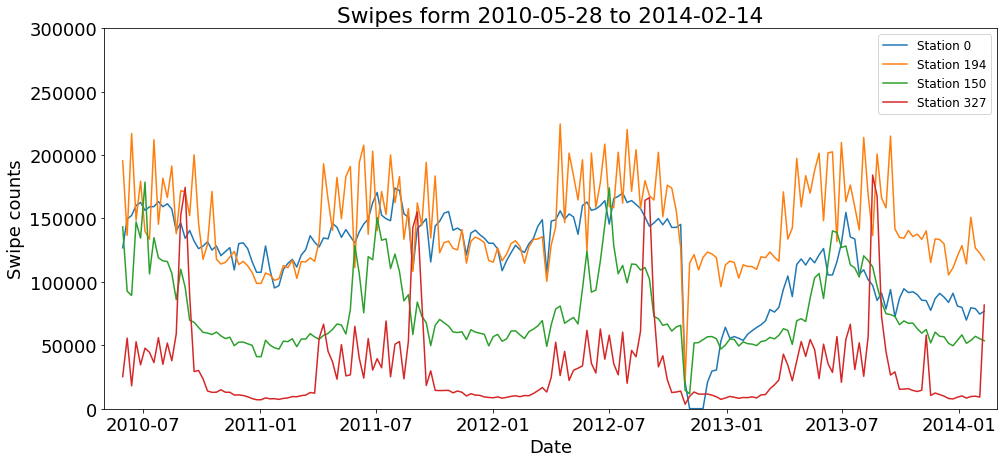

Figure 5. Top 4 stations that show the most prominent periodic trend anually


In [24]:
plt.figure(figsize=(16,7))
for i in stations:
    plt.plot(drange, df1[i], label = "Station "+str(i))
plt.title('Swipes form 2010-05-28 to 2014-02-14')
plt.xlabel('Date')
plt.ylabel('Swipe counts')
plt.xlim(dt.date(2010,5,1), dt.date(2014,3,1))
plt.ylim(-100, 300000)
plt.legend(loc="best", fontsize=12)
plt.show()
print ('Figure 5. Top 4 stations that show the most prominent periodic trend anually')




## EXTRA CREDIT: Cluster. 
### Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 

In [25]:
tots = mtaRide.transpose(2,0,1).reshape(mtaRide.shape[2], mtaRide.shape[1]*mtaRide.shape[0]).T
tots = tots[tots.std(1)>0]
tots.shape

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


(7660, 194)

In [26]:
vals = (tots - np.nanmean(tots, axis=0)) / np.nanstd(tots, axis=0)
vals.shape

(7660, 194)

[  9.89781473e-01   3.22650300e-03   1.91724532e-03   1.15083195e-03
   6.14560214e-04   5.06975839e-04   3.79610886e-04   3.22354209e-04
   2.20011187e-04]


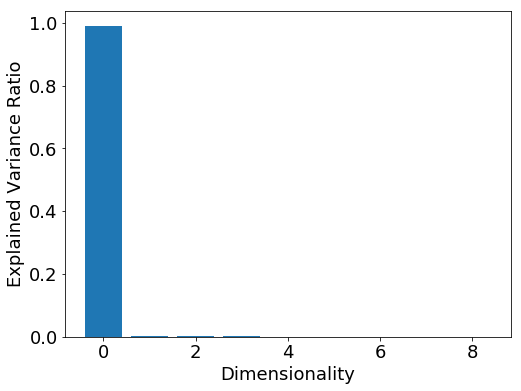

Figure 6. The fraction of variance explained by each principle components. The first two principle components explained more than 99% of variance.


In [27]:
n=9
pca = PCA(n)
Xproj = pca.fit_transform(vals)
eigenvalues = pca.explained_variance_ratio_
print (pca.explained_variance_ratio_)
plt.figure(2, figsize=(8, 6))
plt.bar(np.arange(n), eigenvalues);
plt.xlabel("Dimensionality")
plt.ylabel("Explained Variance Ratio")
plt.show()
print ('Figure 6. The fraction of variance explained by each principle components. ' + 
       'The first two principle components explained more than 99% of variance.')

In [28]:
n=4 # number of clusters
dd=vals #data
#tar=y # real target

#train the model.
km=KMeans(random_state=324,n_clusters=n)
res=km.fit(dd)
#result.
print(res.labels_)

[0 0 0 ..., 0 0 0]


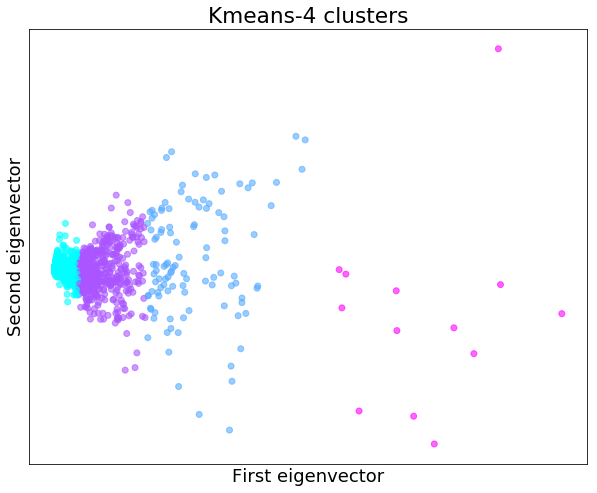

Figure 7. Observations along the first two principle components. Four clusters are plotted.


In [29]:
X = vals
Y = res.labels_
plt.figure(figsize=(10,8))
plt.clf()
plt.scatter(Xproj[:, 0], Xproj[:, 1], c=res.labels_, 
            cmap=plt.cm.cool, alpha=0.6)
plt.xticks(())
plt.yticks(())
plt.title("Kmeans-{} clusters".format(n))
plt.xlabel('First eigenvector')
plt.ylabel('Second eigenvector')
plt.show()
print ('Figure 7. Observations along the first two principle components. ' +
       'Four clusters are plotted.')